In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load training data
Xtr_loadpath = 'Xtr.csv'
Xts_loadpath = 'Xts.csv'
ytr_loadpath = 'ytr.csv'

Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xts = np.loadtxt(Xts_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")

In [3]:
# standardize the training data
Xtr_mean = np.mean(Xtr,axis=0)
Xtr_std = np.std(Xtr,axis=0)
ytr_mean = np.mean(ytr)
ytr_std = np.std(ytr)

Xtr_standardized = ((Xtr-Xtr_mean[None,:])/Xtr_std[None,:]) # revise this line as needed
Xts_standardized = ((Xts-Xtr_mean[None,:])/Xtr_std[None,:]) # revise this line as needed
ytr_standardized = ((ytr-ytr_mean)/ytr_std)

# save the standardized training data
Xtr_savepath = 'Xtr_pytorch.csv'
Xts_savepath = 'Xts_pytorch.csv'
ytr_savepath = 'ytr_pytorch.csv'
yts_hat_savepath = 'yts_hat_pytorch.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xts_savepath, Xts_standardized, delimiter=",")
np.savetxt(ytr_savepath, ytr_standardized, delimiter=",")

In [4]:
# Convert the numpy arrays to PyTorch tensors
Xtr_torch = torch.Tensor(Xtr_standardized)
ytr_torch = torch.Tensor(ytr)

batch_size = 100  # size of each batch

# Create a training Dataset
train_ds = torch.utils.data.TensorDataset(Xtr_torch, ytr_torch)
# Creates a training DataLoader from this Dataset
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True) 


In [5]:
nin = Xtr.shape[1]
nout = 1

model = nn.Sequential(
    # nn.Linear(nin, 2981),
    # nn.ReLU(),
    # nn.BatchNorm1d(2981),
    # nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2

    nn.Linear(nin, 1097),
    nn.ReLU(),
    nn.BatchNorm1d(1097),
    nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2
    
    nn.Linear(1097, 403),
    nn.ReLU(),
    nn.BatchNorm1d(403),
    nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2   
    
    nn.Linear(403, 148),
    nn.ReLU(),
    nn.BatchNorm1d(148),
    nn.Dropout(p=0.5),  # Add dropout layer with probability 0.2  
    
    nn.Linear(148, 55),
    nn.ReLU(),
    nn.Linear(55, 20),
    nn.ReLU(),
    nn.Linear(20, 7),
    nn.ReLU(),
    # nn.Linear(9, 3),
    # nn.ReLU(),
    nn.Linear(7, nout)
)

print(str(model))

Sequential(
  (0): Linear(in_features=26, out_features=1097, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1097, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=1097, out_features=403, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(403, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=403, out_features=148, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(148, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=148, out_features=55, bias=True)
  (13): ReLU()
  (14): Linear(in_features=55, out_features=20, bias=True)
  (15): ReLU()
  (16): Linear(in_features=20, out_features=7, bias=True)
  (17): ReLU()
  (18): Linear(in_features=7, out_features=1, bias=True)
)


In [28]:
# Choosing the optimizer and loss function

epochs = 250
lrate = 6.25e-8
decay = lrate/epochs
lambda1 = lambda epoch: (1-decay)*epoch

opt = optim.AdamW(model.parameters(), weight_decay=0.005, lr=lrate)
#scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.995)
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
criterion = nn.MSELoss()
#criterion = nn.HuberLoss(reduction='mean', delta=30)
#criterion = nn.L1Loss()

In [29]:
# training the model
num_epoch = epochs

a_tr_loss = np.zeros([num_epoch])
a_tr_Rsq = np.zeros([num_epoch])

for epoch in range(num_epoch):

    model.train() # put model in training mode
    batch_loss_tr = []
    batch_Rsq_tr = []
    # iterate over training set
    for train_iter, data in enumerate(train_loader):
        x_batch,y_batch = data
        
        y_batch = y_batch.view(-1,1)
        #y_batch = y_batch.type(torch.long)
        
        out = model(x_batch)
        # Compute Loss
        loss = criterion(out,y_batch.type(torch.float))
        batch_loss_tr.append(loss.item())
        # Compute R-square
        Rsq = r2_score(y_batch.type(torch.float).detach().numpy(), out.detach().numpy())
        batch_Rsq_tr.append(Rsq.item())
        # Compute gradients using back propagation
        opt.zero_grad()
        loss.backward()
        # Take an optimization 'step'
        opt.step()
        
    # Take scheduler step
    scheduler.step()
        
    a_tr_loss[epoch] = np.mean(batch_loss_tr) # Compute average loss over epoch
    a_tr_Rsq[epoch] = np.mean(batch_Rsq_tr)
    if (epoch+1) % 5 == 0:
        print('Epoch: {0:2d}   Train Loss: {1:.3f}   '.format(epoch+1, a_tr_loss[epoch])
             + 'R^2: {0:.3f}   '.format(a_tr_Rsq[epoch])
             )
    
with torch.no_grad():
    predict = model(torch.Tensor(Xtr_standardized)).detach().numpy().ravel()

r2 = r2_score(ytr,predict)
print('training R2: ',r2)
        

Epoch:  5   Train Loss: 15.428   R^2: 0.830   
Epoch: 10   Train Loss: 16.562   R^2: 0.819   
Epoch: 15   Train Loss: 15.598   R^2: 0.822   
Epoch: 20   Train Loss: 15.307   R^2: 0.834   
Epoch: 25   Train Loss: 16.123   R^2: 0.824   
Epoch: 30   Train Loss: 15.691   R^2: 0.823   
Epoch: 35   Train Loss: 15.621   R^2: 0.829   
Epoch: 40   Train Loss: 16.208   R^2: 0.818   
Epoch: 45   Train Loss: 15.750   R^2: 0.822   
Epoch: 50   Train Loss: 15.285   R^2: 0.822   
Epoch: 55   Train Loss: 16.114   R^2: 0.818   
Epoch: 60   Train Loss: 15.256   R^2: 0.821   
Epoch: 65   Train Loss: 15.867   R^2: 0.826   
Epoch: 70   Train Loss: 15.891   R^2: 0.822   
Epoch: 75   Train Loss: 15.447   R^2: 0.827   
Epoch: 80   Train Loss: 15.203   R^2: 0.832   
Epoch: 85   Train Loss: 15.361   R^2: 0.829   
Epoch: 90   Train Loss: 15.569   R^2: 0.823   
Epoch: 95   Train Loss: 15.034   R^2: 0.838   
Epoch: 100   Train Loss: 14.807   R^2: 0.834   
Epoch: 105   Train Loss: 15.636   R^2: 0.832   
Epoch: 110 

Text(0, 0.5, 'Train accuracy')

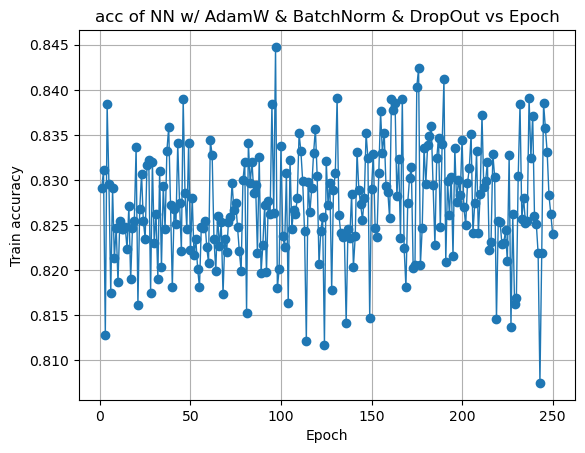

In [30]:
nepochs = len(a_tr_Rsq)
plt.plot(np.arange(1,nepochs+1), a_tr_Rsq, 'o-', linewidth=1)
plt.grid()
plt.title('acc of NN w/ AdamW & BatchNorm & DropOut vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Train accuracy')

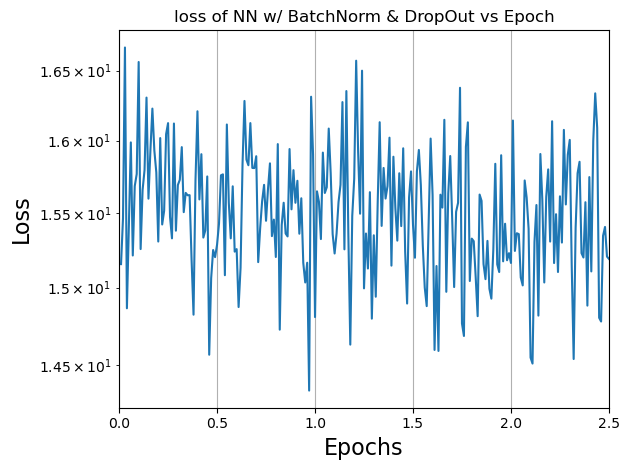

In [31]:
nsteps = len(a_tr_loss)
ntr = Xtr.shape[0]
epochs = np.arange(1,nsteps+1)*batch_size/ntr
plt.semilogy(epochs, a_tr_loss)
plt.title('loss of NN w/ BatchNorm & DropOut vs Epoch')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
plt.xlim([0,np.max(epochs)])
plt.tight_layout()

In [32]:
# save the model: you must use the .pth format for pytorch models!
model_savepath = 'model.pth'

# To save a PyTorch model, we first pass an input through the model, 
# and then save the "trace". 
# For this purpose, we can use any input. 
# We will create a random input with the proper dimension.
x = torch.randn(26) # random input
x = x[None,:] # add singleton batch index
with torch.no_grad():
    traced_cell = torch.jit.trace(model, (x))

# Now we save the trace
torch.jit.save(traced_cell, model_savepath)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1097])

In [33]:
# generate kaggle submission file using the validation script
!python {"validation.py " + model_savepath + " --Xts_path " + Xts_savepath + " --Xtr_path " + Xtr_savepath + " --yts_hat_path " + yts_hat_savepath } 

training R2 =  0.9024598754907031
test target predictions saved in yts_hat_pytorch.csv
